# Class*icle*

https://github.com/EzzEddin/classicle

## Importing Packages

In [0]:
# Preprocessing packages
import csv
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
# Model packages
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, MaxPooling1D, Bidirectional, Dropout
from keras import regularizers
from keras.initializers import RandomUniform, glorot_normal, Orthogonal
from keras import optimizers
from keras.models import load_model
import matplotlib.pyplot as plt

--2020-01-06 13:11:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  24.0MB/s    in 0.2s    

2020-01-06 13:11:39 (24.0 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



## Data

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

## Parameters

In [0]:
version = 'v8'
vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
embedding_dim = 16

## Preprocessing

### Data Cleaning

Cleaning the stopwords from each article

In [0]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [0]:
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertai

Checking if data is balanced or not

In [0]:
txtType = 0
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        if row[0] == 'sport':
          txtType += 1
txtType

511

In [0]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


### Tokenization

#### Training

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

449
120
200
120
192
120


Saving the tokenizer

In [0]:
with open('tokenizer-' + version + '.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)
print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


#### Testing

In [0]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_word_index = label_tokenizer.word_index

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)
print(label_word_index)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)
{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


Saving the label word index

In [0]:
with open('label_word_index.pickle', 'wb') as handle:
    pickle.dump(label_word_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model

### Building

In [0]:
seed_num = 1

# LSTM
lstm_output_size = 6

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, 
                    embeddings_initializer=RandomUniform(minval=-0.05, maxval=0.05, seed=seed_num)))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Bidirectional(LSTM(lstm_output_size,
          kernel_initializer=glorot_normal(seed=seed_num),
          recurrent_initializer=Orthogonal(gain=1.0, seed=seed_num),
          kernel_regularizer=regularizers.l2(0.018),
          recurrent_regularizer=regularizers.l2(0.019),
          activation='relu')))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

### Structure

In [0]:
adam = optimizers.Adam(lr=0.0006, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 16)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 12)                1104      
_________________________________________________________________
dropout_4 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
Total params: 161,182
Trainable params: 161,182
Non-trainable params: 0
________________________________________________

### Fitting

In [0]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq))

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 [==============================] - 10s 6ms/step - loss: 2.6036 - acc: 0.2118 - val_loss: 2.4956 - val_acc: 0.2719
Epoch 2/30
1780/1780 [==============================] - 8s 5ms/step - loss: 2.4059 - acc: 0.2444 - val_loss: 2.3151 - val_acc: 0.2382
Epoch 3/30
1780/1780 [==============================] - 8s 5ms/step - loss: 2.2347 - acc: 0.2337 - val_loss: 2.1540 - val_acc: 0.2382
Epoch 4/30
1780/1780 [==============================] - 8s 5ms/step - loss: 2.0906 - acc: 0.2225 - val_loss: 2.0161 - val_acc: 0.2382
Epoch 5/30
1780/1780 [==============================] - 8s 5ms/step - loss: 1.9616 - acc: 0.2242 - val_loss: 1.8745 - val_acc: 0.2382
Epoch 6/30
1780/1780 [==============================] - 8s 5ms/step - loss: 1.7721 - acc: 0.2511 - val_loss: 1.6462 - val_acc: 0.2764
Epoch 7/30
1780/1780 [==============================] - 8s 5ms/step - loss: 1.5380 - acc: 0.3590 - val_loss: 1.4263 - val_acc: 0.4270
Epoch 8/30
178

### Visualization

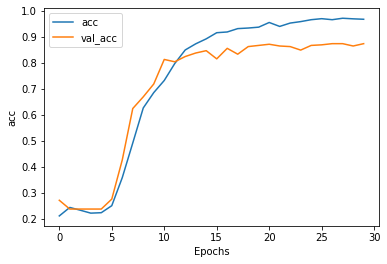

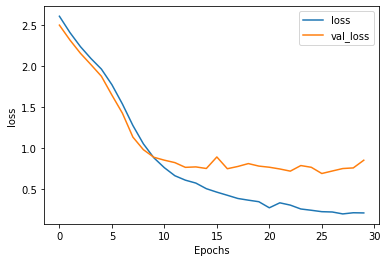

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

### Testing

In [0]:
sentences[0]

'tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertainment. us

In [0]:
tst1 = "tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite companies worried means terms advertising revenues well  brand identity  viewer loyalty channels. although us leads technology moment  also concern raised europe  particularly growing uptake services like sky+.  happens today  will see nine months years  time uk   adam hume  bbc broadcast s futurologist told bbc news website. likes bbc  no issues lost advertising revenue yet. pressing issue moment commercial uk broadcasters  brand loyalty important everyone.  will talking content brands rather network brands   said tim hanlon  brand communications firm starcom mediavest.  reality broadband connections  anybody can producer content.  added:  challenge now hard promote programme much choice.   means  said stacey jolna  senior vice president tv guide tv group  way people find content want watch simplified tv viewers. means networks  us terms  channels take leaf google s book search engine future  instead scheduler help people find want watch. kind channel model might work younger ipod generation used taking control gadgets play them. "
seed_text = tst1[:int(len(tst1)*0.3)]
token_list = tokenizer.texts_to_sequences([seed_text])[0]

token_list_padded = pad_sequences([token_list], maxlen=max_length, padding=padding_type)
predicted = model.predict_classes(token_list_padded, verbose=0)
for label in label_word_index.values():
  if predicted[0] == label:
    print(list(label_word_index.keys())[label-1])

sport


### Evaluation

In [0]:
score, acc = model.evaluate(validation_padded, validation_label_seq)
print('Test score:', score)
print('Test accuracy:', acc)

445/445 [==============================] - 1s 2ms/step
Test score: 0.8547006842795383
Test accuracy: 0.8741573051120458


### Saving

In [0]:
model.save('model-bilstm_reg8.h5')  # creates a HDF5 file 'my_model.h5'